In [191]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import read_quote      as rq
import stock_functions as sf
import df_visualizations as dv
import remap_values as rv
import fill_values as fv

import random
import pickle

import sys
import time

In [2]:
from sklearn.svm            import SVR
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble       import BaggingRegressor
from sklearn.ensemble       import AdaBoostRegressor

from sklearn.multioutput    import MultiOutputRegressor

from sklearn.utils          import shuffle

from sklearn.metrics        import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.multioutput    import MultiOutputRegressor

In [3]:
%matplotlib inline
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14, 10)

In [4]:
roll_nums = [3,5,8,10,15,20,25,30]  # Generate an algorithm for predicting every few days
mom_nums  = [3,5,8,10,15,20,25,30]  # Momentum has many good tracers
rsi_nums  = [10,15,20,25,30]        # Good for some long term trends
band_nums = [5,8,10,15,20,25]       # A few trace different areas well

In [5]:
inpFileList = ['aapl','acm' ,'awk' ,'amzn','awr' ,'ba'  ,'bac' ,'c'   ,'cat' ,'cop' ,'cvx' ,'dal' ,
               'dd'  ,'farm','fdp' ,'gnc' ,'hes' ,'ibm' ,'mas' ,'mcd' ,'mon' ,'msex','msft','nflx',
               'sbux','strl','tgt' ,'tsla','ups' ,'xom' ,'xpo' ,'vmc' ]

In [6]:
scaled_df = sf.get_scaled_data( inpFileList, roll_nums, mom_nums, rsi_nums, band_nums )

In [6]:
#scaled_df = sf.gen_pca_attributes( scaled_df, mom_nums, rsi_nums, band_nums, n_mom=3, n_rsi=2, n_ban=2 )

In [7]:
# Read in each stock, and perform reduction
#    Break into train, test sets
#    Store train, test sets in arrays
# For each regressor predicting a certain num of days...
#    Manually cross validate, testing and scoring each set

In [7]:
# Mix up the list
shuff_scaled_df = shuffle( scaled_df )


# Seperate features from target data
close_list = ['close']
for i in roll_nums:
    close_list.append( 'close_mean_'+str(i) )

targets  = shuff_scaled_df[close_list]
features = shuff_scaled_df.drop( close_list, axis=1 )



n_elements = shuff_scaled_df.shape[0]

# Set the fraction of data we will train over
percent_train = 0.8

# Size of training set
n_train = int( percent_train * n_elements )


# Seperate training and test data
train_features = features[ : n_train   ]
test_features  = features[   n_train : ]

train_targets  =  targets[ : n_train   ].drop( 'close', axis=1 )
test_targets   =  targets[   n_train : ].drop( 'close', axis=1 )

In [8]:
# Gets the location of not null values
train_not_null_locations = train_targets.notnull().all( axis=1 )==1
test_not_null_locations  =  test_targets.notnull().all( axis=1 )==1

# Take features and targets that are not null
train_x = train_features[ train_not_null_locations ].values
test_x  =  test_features[  test_not_null_locations ].values

train_y = train_targets[ train_not_null_locations ].values
test_y  =  test_targets[  test_not_null_locations ].values

ad_mult_reg = MultiOutputRegressor( AdaBoostRegressor( base_estimator=RandomForestRegressor( n_estimators=20, max_features=0.7 ), 
#                            loss='exponential', n_estimators=10 ) )
                            loss='exponential', n_estimators=5 ) )
#                            loss='exponential', n_estimators=3 ) )

ad_mult_reg.fit( train_x, train_y )

MultiOutputRegressor(estimator=AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.7, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
         learning_rate=1.0, loss='exponential', n_estimators=5,
         random_state=None),
           n_jobs=1)

In [9]:
test_60 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] ) ) :
    mse = mean_squared_error( test_y[i-1], test_60[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.28736, Percent ME : 36.03992
 close_mean_5 MSE :  0.01817, Percent ME :  9.06243
 close_mean_7 MSE :  0.02099, Percent ME :  9.73959
close_mean_10 MSE :  0.00909, Percent ME :  6.41166
close_mean_12 MSE :  0.02232, Percent ME : 10.04452
close_mean_15 MSE :  0.02216, Percent ME : 10.00922


In [29]:
test_70 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] ) ) :
    mse = mean_squared_error( test_y[i-1], test_70[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.11175, Percent ME : 22.26275
 close_mean_5 MSE :  0.02046, Percent ME :  9.52490
 close_mean_7 MSE :  0.01597, Percent ME :  8.41539
close_mean_10 MSE :  0.00119, Percent ME :  2.29876
close_mean_12 MSE :  0.23849, Percent ME : 32.52288
close_mean_15 MSE :  0.26986, Percent ME : 34.59590


In [12]:
test_80 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.00034, Percent ME :  1.28400
 close_mean_5 MSE :  0.00052, Percent ME :  1.57940
 close_mean_7 MSE :  0.00769, Percent ME :  6.09548
close_mean_10 MSE :  0.00520, Percent ME :  5.01383
close_mean_12 MSE :  0.04772, Percent ME : 15.18780
close_mean_15 MSE :  0.01710, Percent ME :  9.09208
close_mean_20 MSE :  0.04250, Percent ME : 14.33349
close_mean_25 MSE :  0.10339, Percent ME : 22.35573


In [8]:
test_80_5 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_5[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.00052, Percent ME :  1.58310
 close_mean_5 MSE :  0.01097, Percent ME :  7.28296
 close_mean_7 MSE :  0.02160, Percent ME : 10.21904
close_mean_10 MSE :  0.00542, Percent ME :  5.11623
close_mean_12 MSE :  0.04154, Percent ME : 14.17041
close_mean_15 MSE :  0.01140, Percent ME :  7.42228
close_mean_20 MSE :  0.01214, Percent ME :  7.66086
close_mean_25 MSE :  0.06858, Percent ME : 18.20686


In [8]:
test_all = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_all[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.04622, Percent ME : 16.03829
 close_mean_5 MSE :  0.00280, Percent ME :  3.95061
 close_mean_7 MSE :  0.06953, Percent ME : 19.67037
close_mean_10 MSE :  0.03379, Percent ME : 13.71227
close_mean_12 MSE :  0.00471, Percent ME :  5.11735
close_mean_15 MSE :  0.26712, Percent ME : 38.55589
close_mean_18 MSE :  0.02227, Percent ME : 11.13333
close_mean_20 MSE :  0.00127, Percent ME :  2.66170
close_mean_23 MSE :  0.00853, Percent ME :  6.89029
close_mean_25 MSE :  0.02849, Percent ME : 12.59120
close_mean_28 MSE :  0.00738, Percent ME :  6.40677
close_mean_30 MSE :  0.02438, Percent ME : 11.64905


In [8]:
test_80_3_all = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_3_all[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.01164, Percent ME :  8.63749
 close_mean_5 MSE :  0.00212, Percent ME :  3.68463
 close_mean_7 MSE :  0.08406, Percent ME : 23.21046
close_mean_10 MSE :  0.00056, Percent ME :  1.89508
close_mean_12 MSE :  0.00012, Percent ME :  0.86886
close_mean_15 MSE :  0.00403, Percent ME :  5.08291
close_mean_18 MSE :  0.01355, Percent ME :  9.31947
close_mean_20 MSE :  0.04023, Percent ME : 16.05616
close_mean_23 MSE :  0.00035, Percent ME :  1.48873
close_mean_25 MSE :  0.00362, Percent ME :  4.81892
close_mean_28 MSE :  0.08284, Percent ME : 23.04127
close_mean_30 MSE :  0.00043, Percent ME :  1.66966


In [9]:
test_80_3_most = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_3_most[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(abs(test_y) ) )

 close_mean_3 MSE :  0.00222, Percent ME :  0.42910
 close_mean_5 MSE :  0.01836, Percent ME :  1.23313
 close_mean_8 MSE :  0.01501, Percent ME :  1.11468
close_mean_10 MSE :  0.01245, Percent ME :  1.01514
close_mean_15 MSE :  0.00850, Percent ME :  0.83905
close_mean_20 MSE :  0.01199, Percent ME :  0.99655
close_mean_25 MSE :  0.00141, Percent ME :  0.34111
close_mean_30 MSE :  0.00918, Percent ME :  0.87200


In [9]:
test_80_5_most = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_5_most[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.00385, Percent ME :  9.99972
 close_mean_5 MSE :  0.00011, Percent ME :  1.69317
 close_mean_8 MSE :  0.02368, Percent ME : 24.80523
close_mean_10 MSE :  0.00171, Percent ME :  6.66250
close_mean_15 MSE :  0.00008, Percent ME :  1.46269
close_mean_20 MSE :  0.00089, Percent ME :  4.81670
close_mean_25 MSE :  0.00033, Percent ME :  2.94020
close_mean_30 MSE :  0.00023, Percent ME :  2.41817


In [10]:
pred_values = test_80_5_most

std_dict = {}

for i in range( 0, len( close_list[1:] ) ) :
    rmse = np.sqrt( mean_squared_error( test_y[i], pred_values[i] ) )
    col  = 'std_' + str( roll_nums[i] )
    std_dict[col] = rmse
    print '%13s   RMSE : %8.5f,   RMSE/mean : %8.5f' % ( close_list[i+1], rmse, rmse/np.mean( abs(test_y)) )
    
print std_dict

 close_mean_3   RMSE :  0.06204,   RMSE/mean :  1.33976
 close_mean_5   RMSE :  0.01050,   RMSE/mean :  0.22685
 close_mean_8   RMSE :  0.15389,   RMSE/mean :  3.32340
close_mean_10   RMSE :  0.04133,   RMSE/mean :  0.89264
close_mean_15   RMSE :  0.00907,   RMSE/mean :  0.19597
close_mean_20   RMSE :  0.02988,   RMSE/mean :  0.64534
close_mean_25   RMSE :  0.01824,   RMSE/mean :  0.39393
close_mean_30   RMSE :  0.01500,   RMSE/mean :  0.32399
{'std_25': 0.018240264159727265, 'std_30': 0.015001722433243388, 'std_20': 0.029881622922671106, 'std_15': 0.0090741700991440674, 'std_10': 0.041332526285400115, 'std_5': 0.010504012864607648, 'std_3': 0.062035796486686258, 'std_8': 0.15388549520813605}


In [259]:
quote_name = 'aapl'


# Generate df with the actual rolling averages
close_df = rq.readQuote( 'quotes/'+ quote_name +'.csv' )
close_df = pd.merge( close_df['close'].to_frame(), sf.generate_rolling_close( close_df, roll_nums, onlyMean=True ), left_index=True, right_index=True )
close_means = close_df.columns.values


# Generate predicted rolling mean percentage increases
pred_df     = sf.get_scaled_data( [quote_name], roll_nums, mom_nums, rsi_nums, band_nums ).dropna()
pred_values = ad_mult_reg.predict( pred_df.drop( close_means, axis=1 ) )


# Adjust close to match pred df shape
close_df = close_df.ix[ pred_df.index.values ].dropna()

# Pred percent increase = future/now - 1
for i in range( 0 , pred_values.shape[1] ):
    close_df[ 'pred_mean_' + str( roll_nums[i] ) ] = ( pred_values[:,i] + 1 ) * close_df[ 'close_mean_' + str( roll_nums[i] ) ]
    close_df[ 'pred_mean_' + str( roll_nums[i] ) ] = close_df[ 'pred_mean_' + str( roll_nums[i] ) ].shift( -roll_nums[i]+1 )
#    close_df[ 'pred_mean_' + str( roll_nums[i] ) ] = ( close_df[ 'pred_mean_' + str( roll_nums[i] ) ] + 
#                                                       close_df[ 'pred_mean_' + str( roll_nums[i] ) ].shift(-1) ) / 2.
close_df = close_df.dropna()

In [195]:
close_df.head(10)

,close,close_mean_3,close_mean_5,close_mean_8,close_mean_10,close_mean_15,close_mean_20,close_mean_25,close_mean_30,pred_mean_3,pred_mean_5,pred_mean_8,pred_mean_10,pred_mean_15,pred_mean_20,pred_mean_25,pred_mean_30
date,,,,,,,,,,,,,,,,,
2017/01/26,121.94,121.263333,120.774,120.45500,120.193,119.620000,118.7890,118.3944,117.955667,120.408421,121.074918,121.006485,120.090055,119.551080,116.639000,118.271111,117.851365
2017/01/25,121.88,120.643333,120.342,120.09250,119.974,119.225333,118.5550,118.1824,117.667667,120.875997,120.448427,120.351622,120.146461,116.102124,117.168526,117.536773,116.987401
2017/01/24,119.97,120.016667,119.964,119.76375,119.697,118.843333,118.2870,117.9460,117.403333,120.606128,120.237282,119.638867,119.853377,117.008627,115.522917,118.088063,116.481405
2017/01/23,120.08,119.953333,119.970,119.73625,119.599,118.566667,118.1030,117.7800,117.141667,120.305391,119.745644,119.957712,119.596789,117.258607,116.567954,117.124420,116.307893
2017/01/20,120.00,119.923333,119.762,119.61500,119.382,118.343333,117.9520,117.5844,116.840000,120.130340,119.339763,119.534899,117.723037,117.880729,117.533692,117.386982,111.142907
2017/01/19,119.78,119.923333,119.612,119.48875,119.043,118.127333,117.7995,117.3920,116.505000,119.982925,119.712295,119.365247,118.892190,117.129416,117.466773,116.623291,114.420735
2017/01/18,119.99,119.676667,119.606,119.25500,118.667,117.959333,117.6425,117.1328,116.149333,119.624635,119.660125,118.536030,115.915581,117.359075,117.579991,115.211920,111.515747
2017/01/17,120.00,119.430000,119.430,118.83250,118.283,117.728000,117.4415,116.8912,115.813000,119.731869,119.243771,118.590724,115.082914,117.025109,116.545823,116.810723,113.234806
2017/01/13,119.04,119.346667,119.228,118.33500,117.865,117.480667,117.2325,116.5760,115.462667,119.745730,118.846403,116.706443,116.140896,117.121178,116.289144,115.635537,113.929462


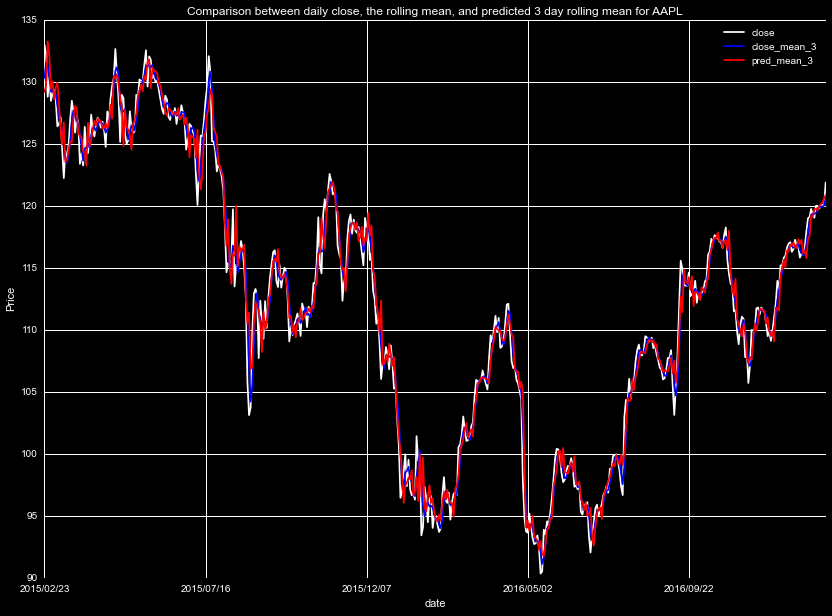

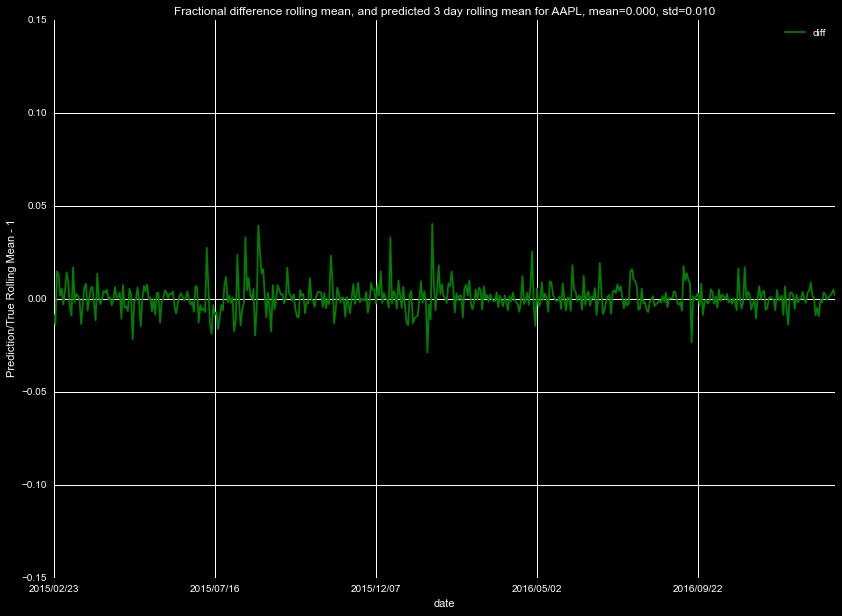

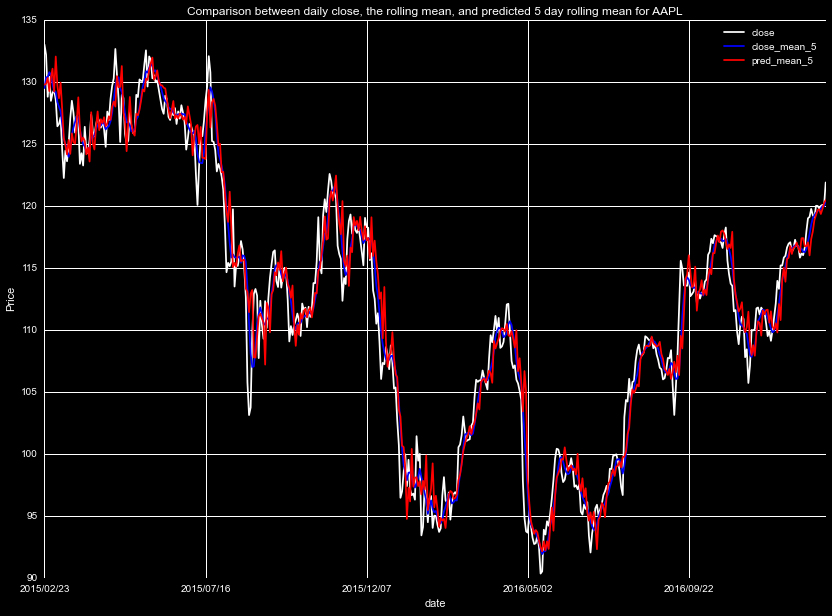

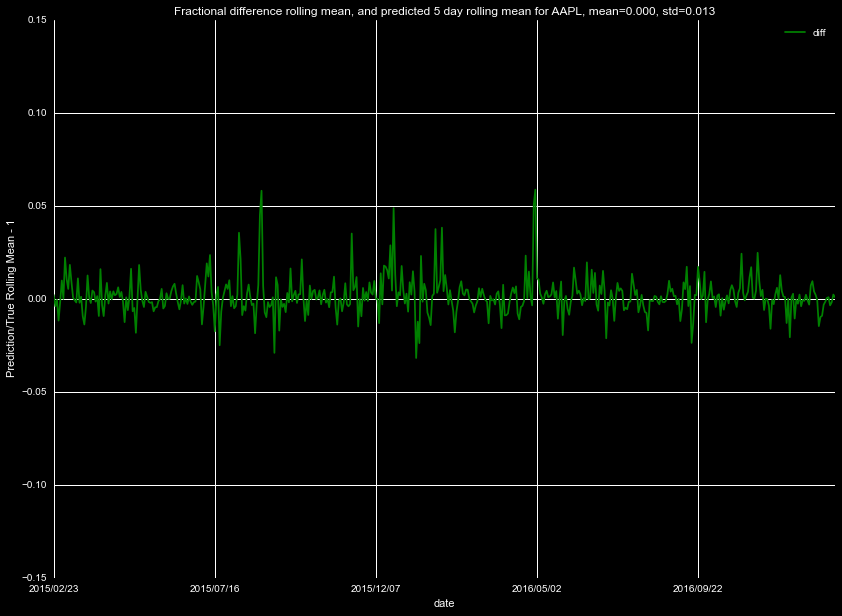

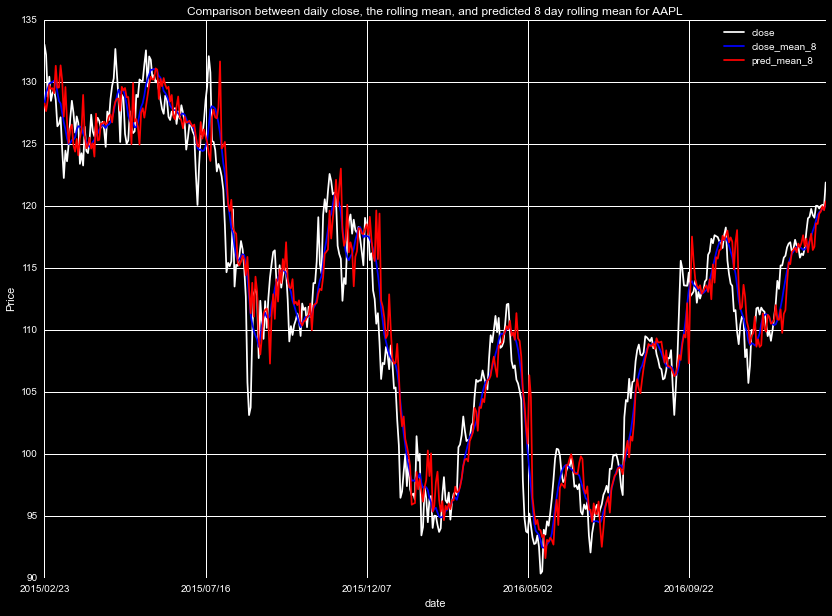

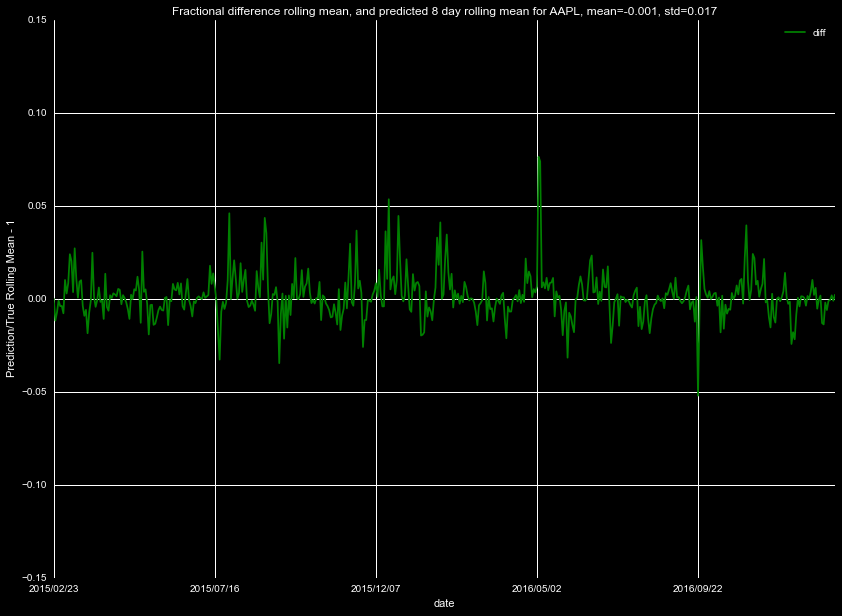

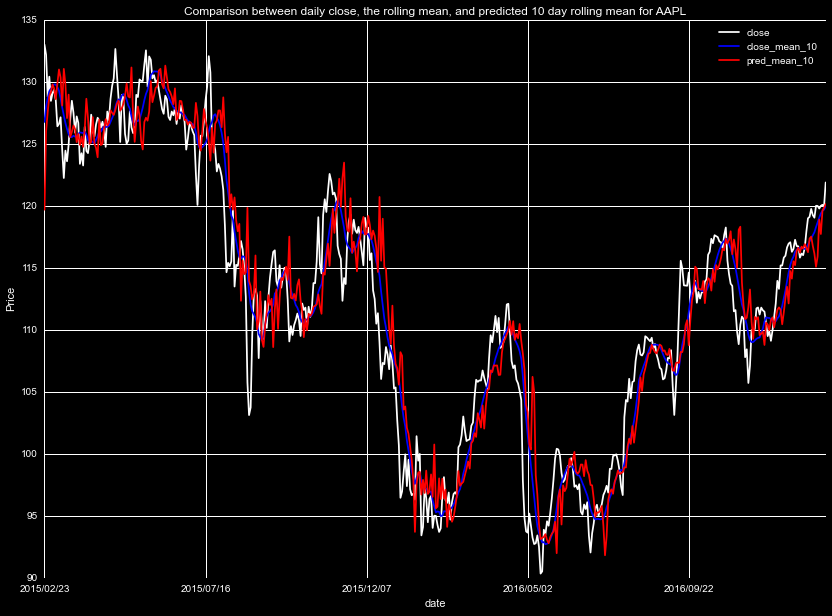

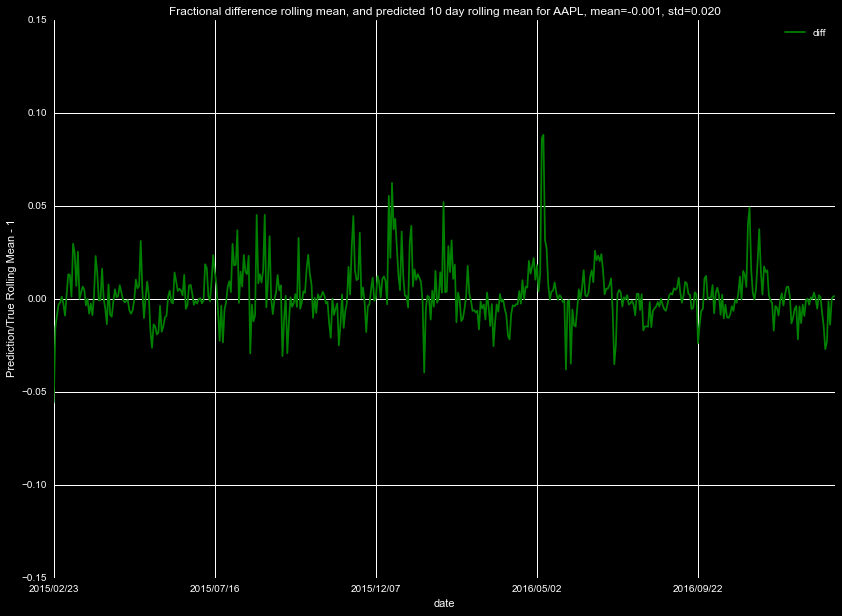

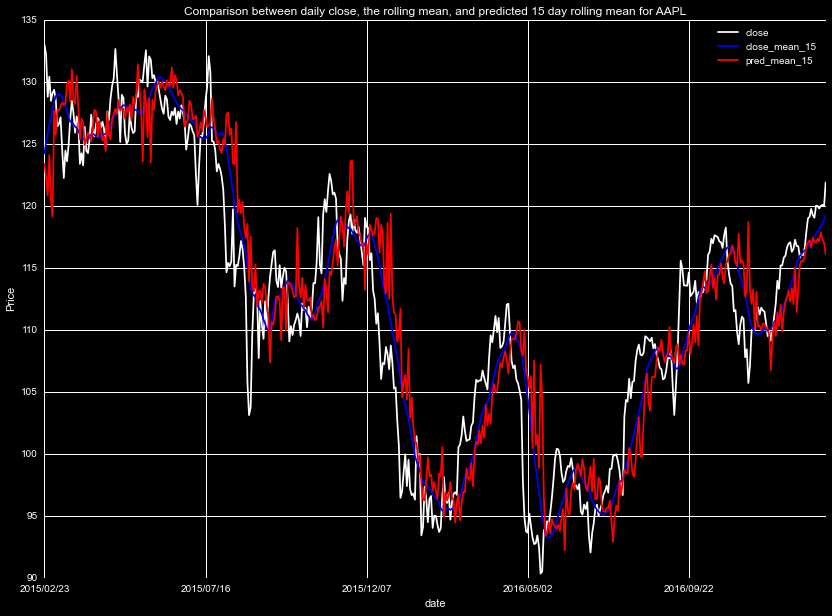

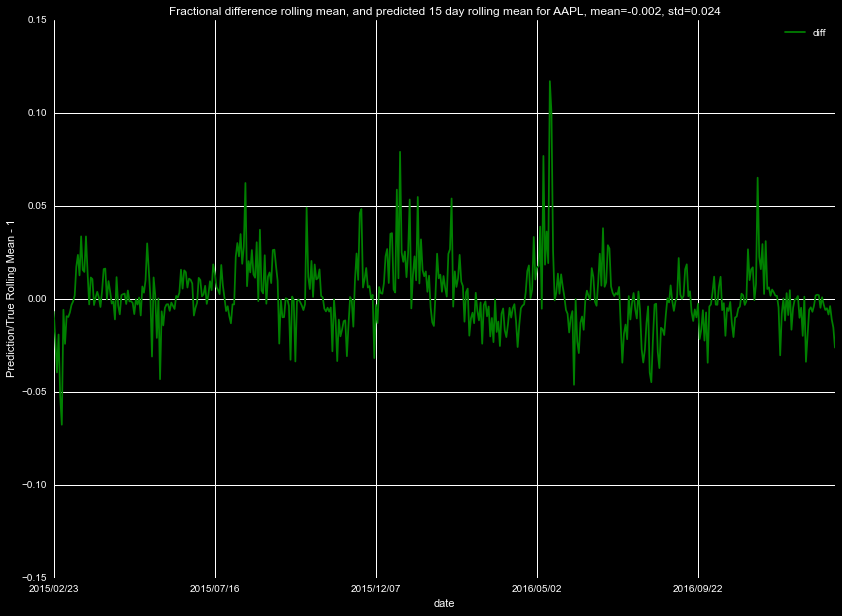

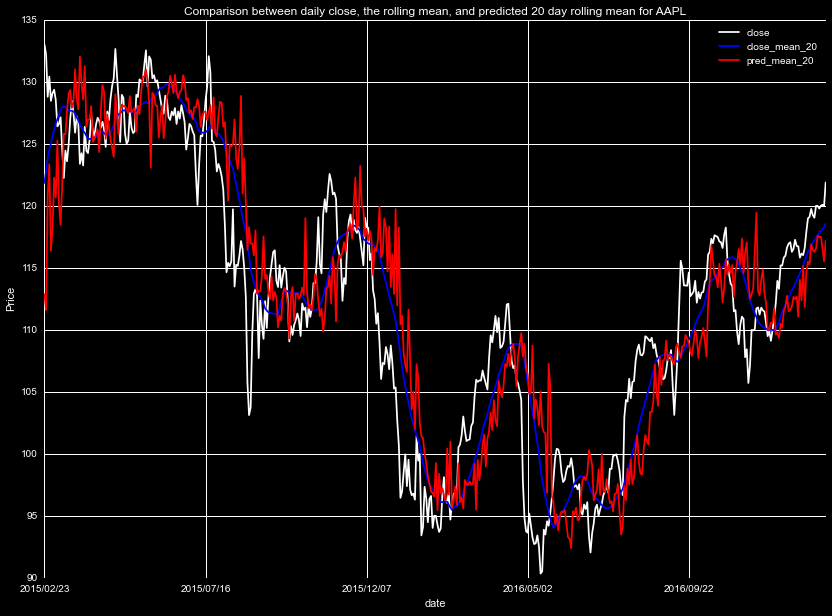

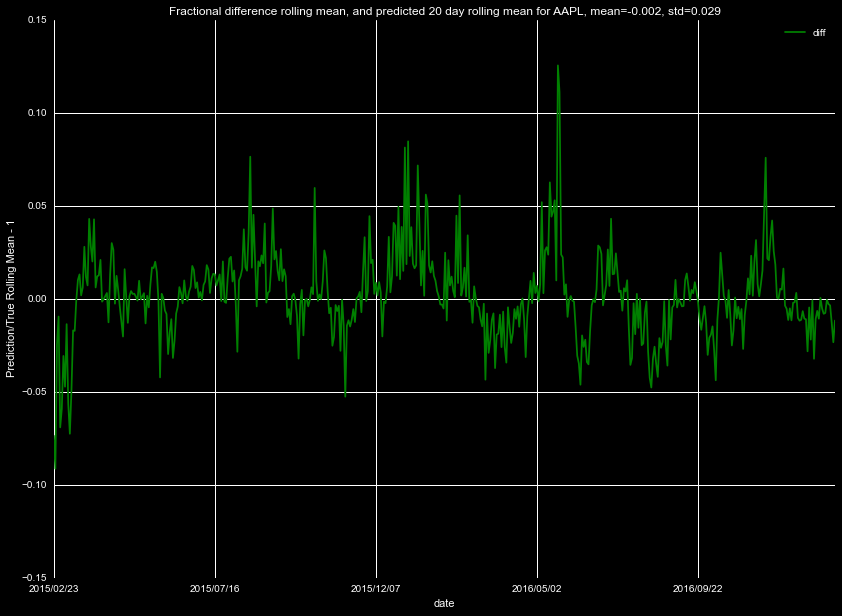

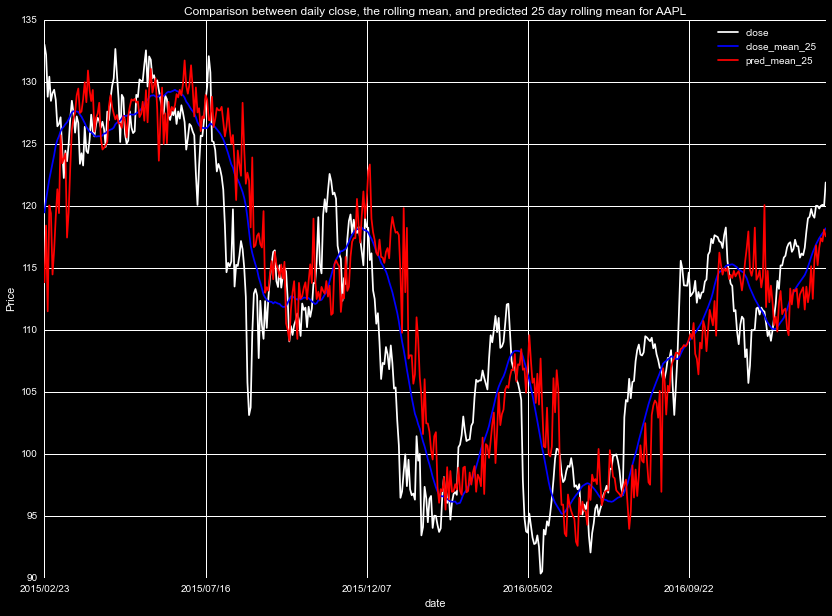

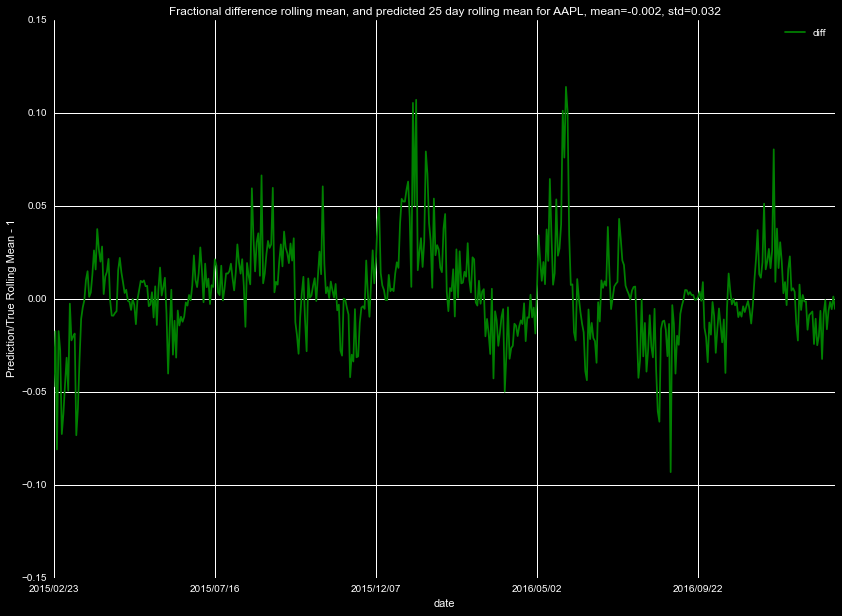

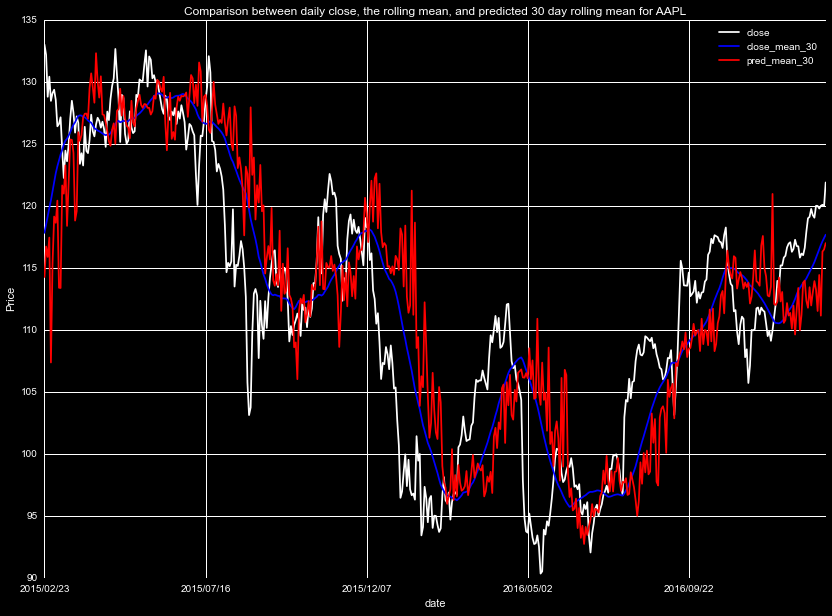

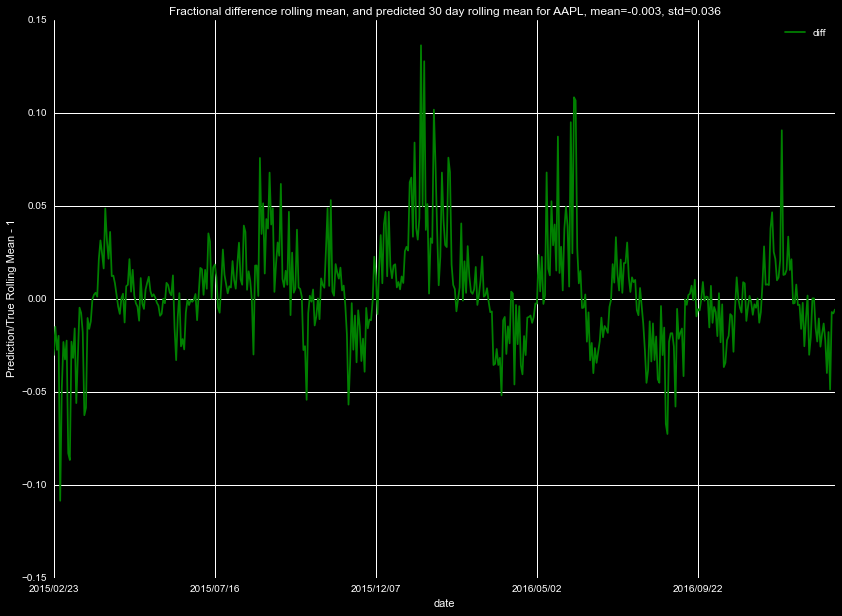

In [260]:
max_ind = close_df.shape[0]
low = int( 0.0*max_ind )
hi  = int( 0.2*max_ind )
for i in roll_nums:
    my_ax = plt.gca()
    close_df[hi:low:-1].plot( y = 'close'             , color='w', ax=my_ax )
    close_df[hi:low:-1].plot( y = 'close_mean_'+str(i), color='b', ax=my_ax )
    close_df[hi:low:-1].plot( y =  'pred_mean_'+str(i), color='r', ax=my_ax )
    plt.title( 'Comparison between daily close, the rolling mean, and predicted ' + str(i) + ' day rolling mean for AAPL' )
    plt.ylabel( 'Price' )
    plt.show()
    
    my_ax = plt.gca()
    close_df['diff'] = close_df['pred_mean_'+str(i)] / close_df['close_mean_'+str(i)] - 1.
    close_df[hi:low:-1].plot( y='diff', color='g', ax=my_ax )
    plt.title( 'Fractional difference rolling mean, and predicted ' + str(i) + 
               ' day rolling mean for AAPL, mean=%5.3f, std=%5.3f'%(close_df['diff'].mean(),close_df['diff'].std()) )
    plt.ylabel( 'Prediction/True Rolling Mean - 1' )
    plt.ylim( [-0.15,0.15] )
    plt.show()

In [68]:
# Some values noisy, lets test the trend in rolling means

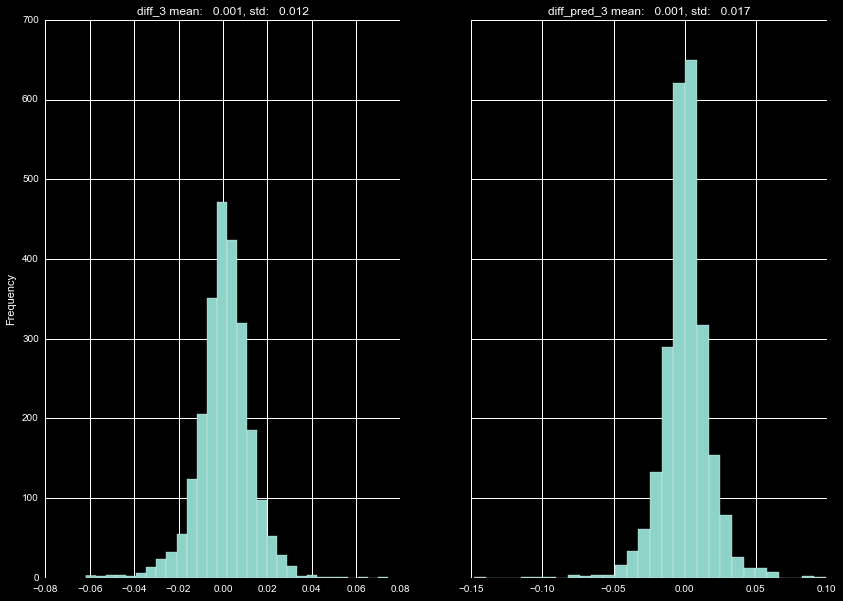

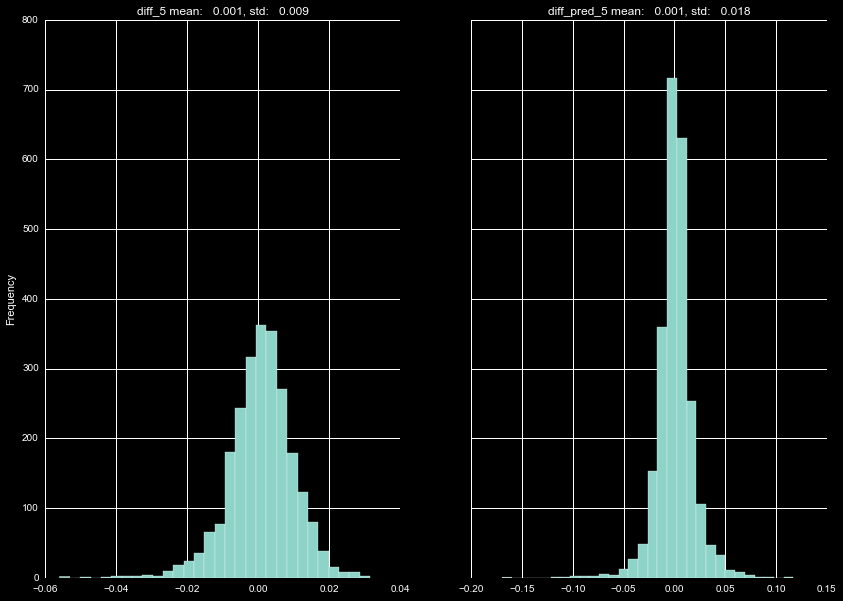

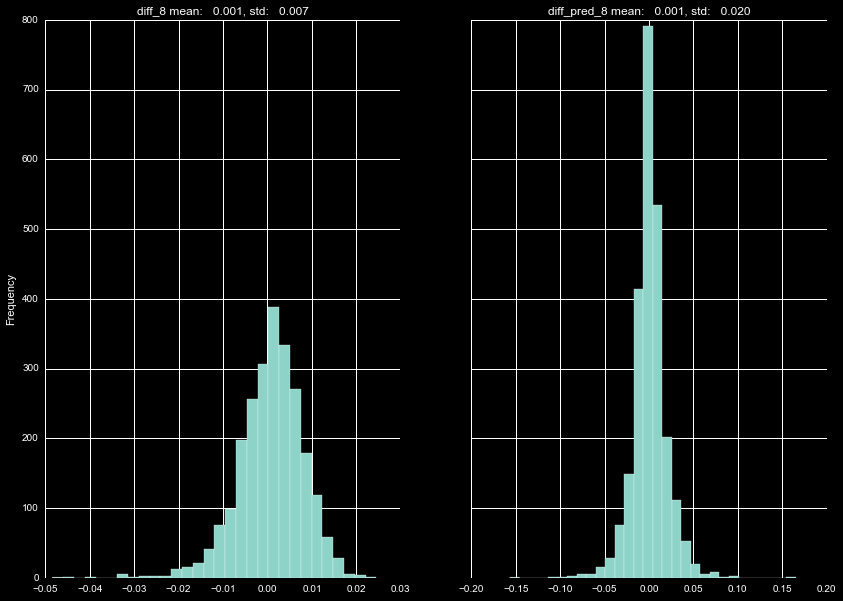

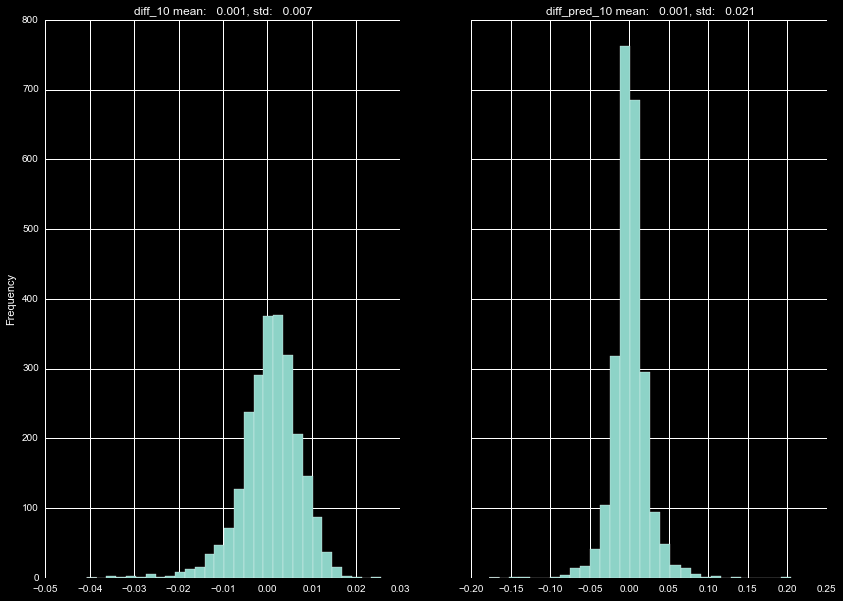

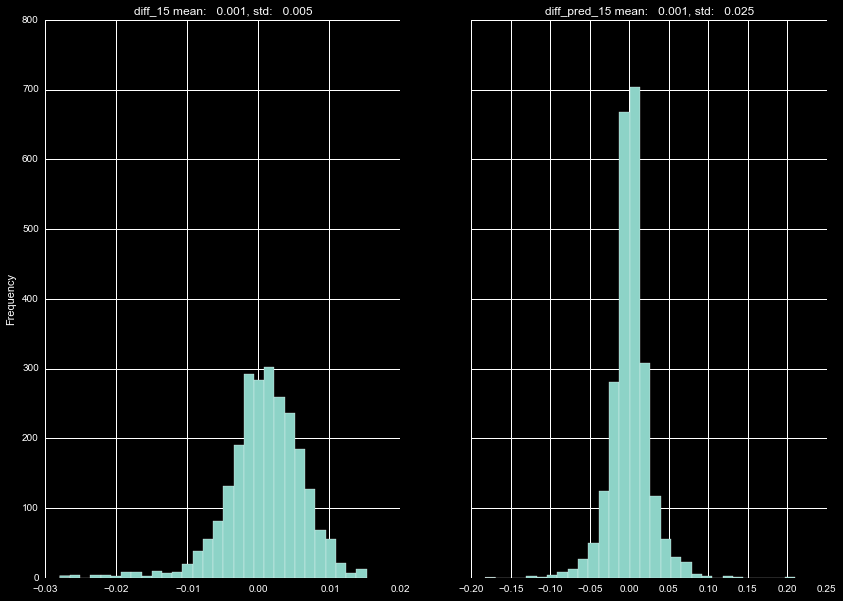

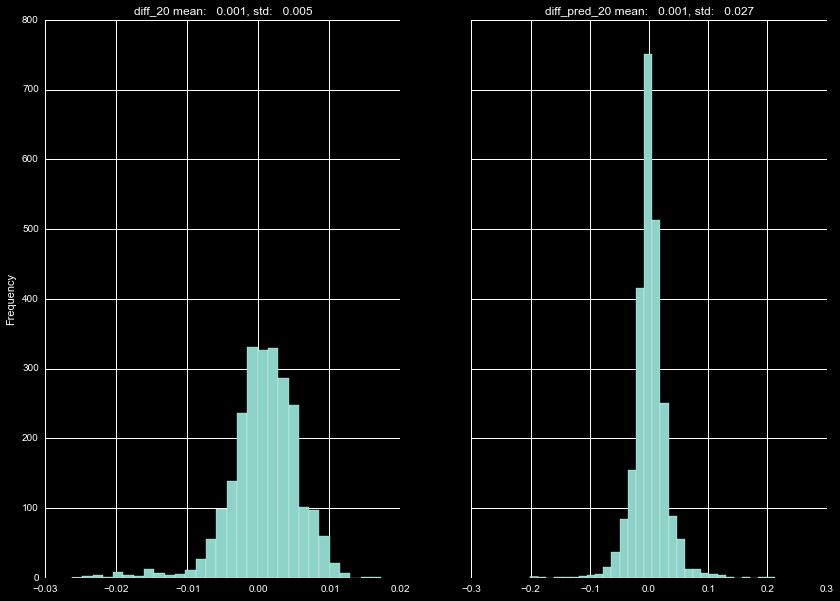

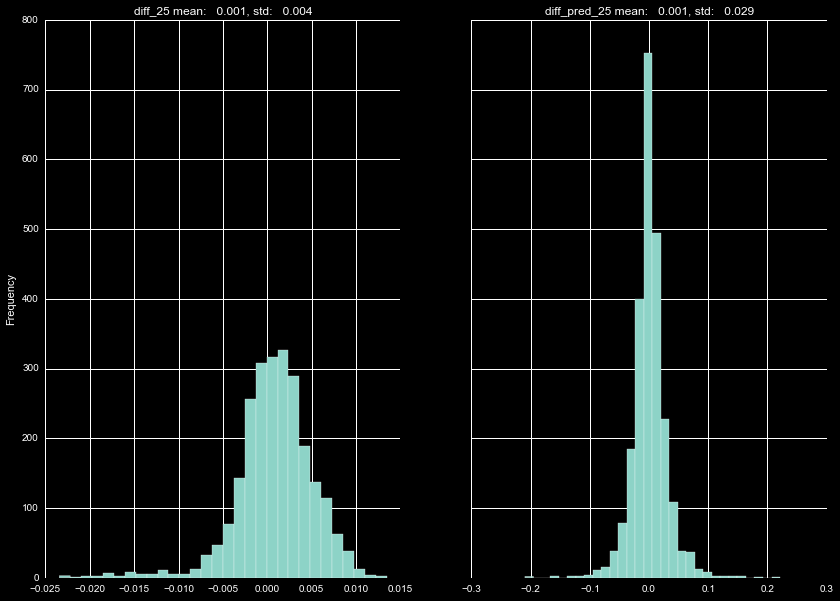

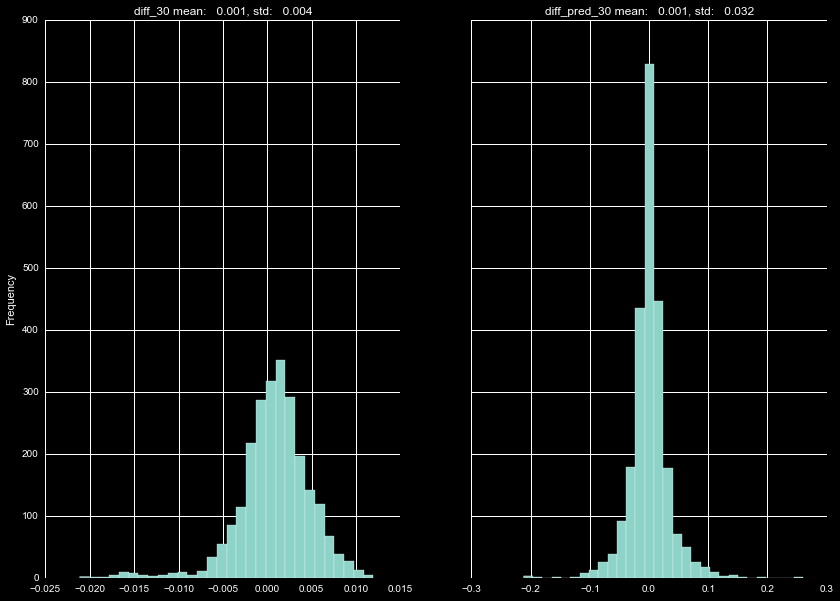

In [261]:
rolling_df = close_df.copy()

std_diff = {}

for i in roll_nums:
    rolling_df['diff_'     +str(i)] = close_df['close_mean_'+str(i)]/close_df['close_mean_'+str(i)].shift(-1) - 1.
    rolling_df['diff_pred_'+str(i)] = close_df[ 'pred_mean_'+str(i)]/close_df[ 'pred_mean_'+str(i)].shift(-1) - 1.
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    rolling_df[    'diff_'     +str(i)].plot.hist( bins=30, ax=ax1 )
    rolling_df[    'diff_pred_'+str(i)].plot.hist( bins=30, ax=ax2 )
    ax1.set_title( 'diff_'     +str(i)+ ' mean: %7.3f, std: %7.3f ' % (rolling_df['diff_'     +str(i)].mean(),
                                                                       rolling_df['diff_'     +str(i)].std()) )
    ax2.set_title( 'diff_pred_'+str(i)+ ' mean: %7.3f, std: %7.3f ' % (rolling_df['diff_pred_'+str(i)].mean(),
                                                                       rolling_df['diff_pred_'+str(i)].std()) )
    plt.show()
    
    std_diff['std_'+str(i)] = rolling_df['diff_'     +str(i)].std()/rolling_df['diff_pred_'+str(i)].std()

In [262]:
std_diff

{'std_10': 0.30525201045221007,
 'std_15': 0.21951987542455118,
 'std_20': 0.17492845777022328,
 'std_25': 0.14701605522567163,
 'std_3': 0.7123927714969664,
 'std_30': 0.12487586999664722,
 'std_5': 0.5054140056420483,
 'std_8': 0.37292184693965186}

In [285]:
smooth_vals = [0,0,2,2,3,4,5,6]
shift_vals  = [0,0,2,2,3,4,5,6]


# Tweak the difference in rolling means per day
# Lots of noise, this may force less noise, might not. We will see
for i in range( 0, len(roll_nums) ):
    
    roll = str( roll_nums[i] )
    if ( smooth_vals[i] > 1 ):
        close_df['new_mean_'+roll] = close_df['pred_mean_'+roll].values[::-1]
        close_df['new_mean_'+roll] = close_df[ 'new_mean_'+roll].rolling(smooth_vals[i]).mean()
        close_df['new_mean_'+roll] = close_df[ 'new_mean_'+roll].shift(-shift_vals[i])
        close_df['new_mean_'+roll] = close_df[ 'new_mean_'+roll].values[::-1]
    else:
        close_df['new_mean_'+roll] = close_df['pred_mean_'+roll]

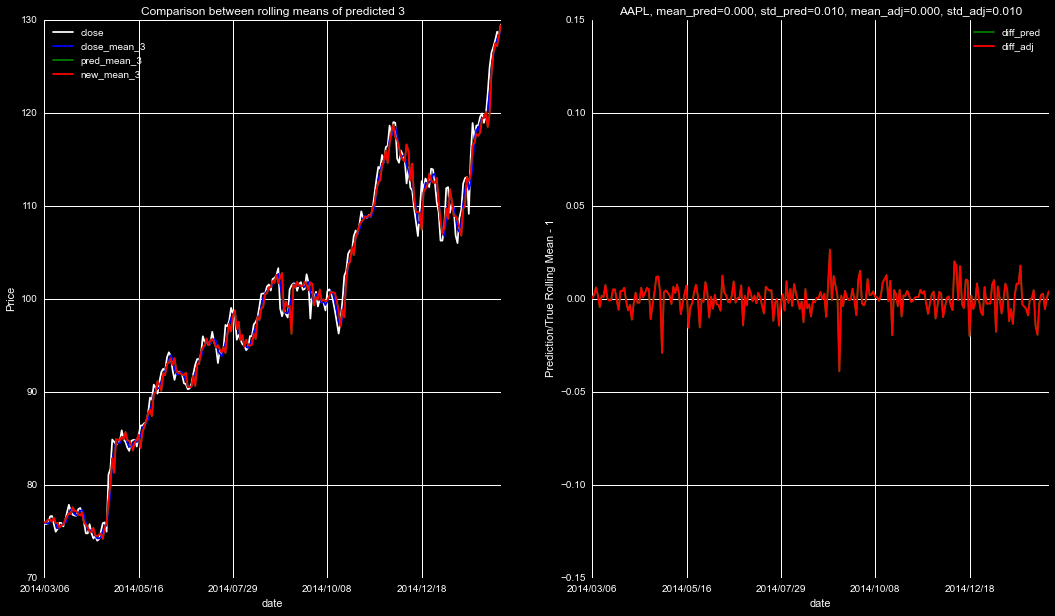

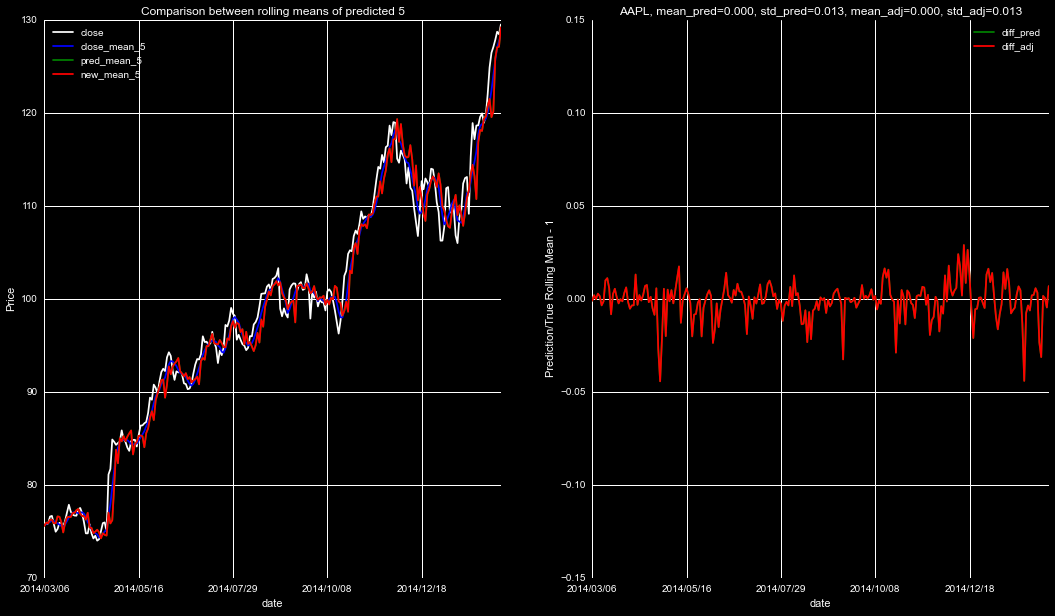

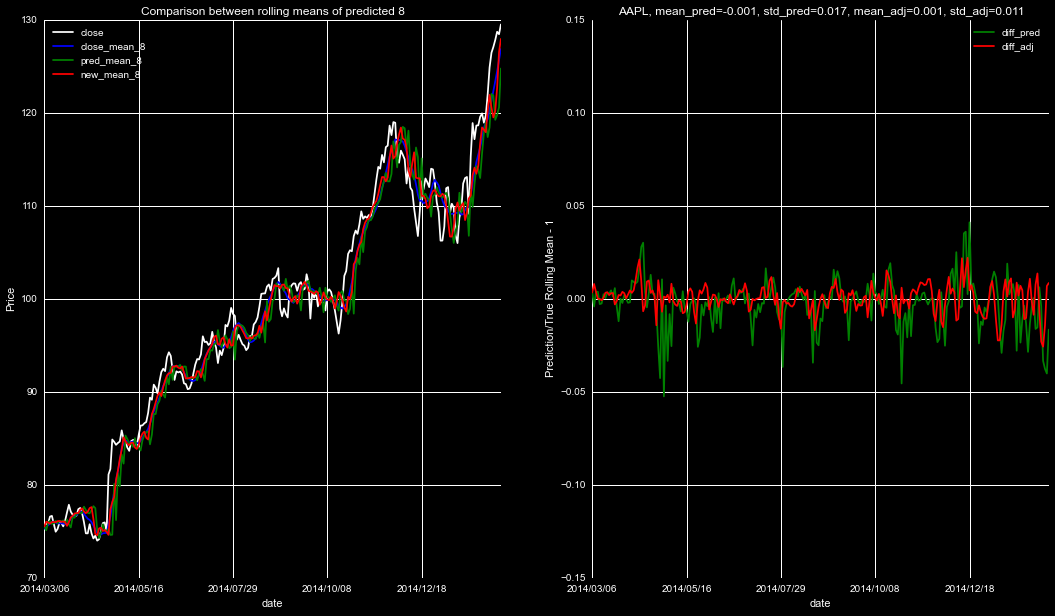

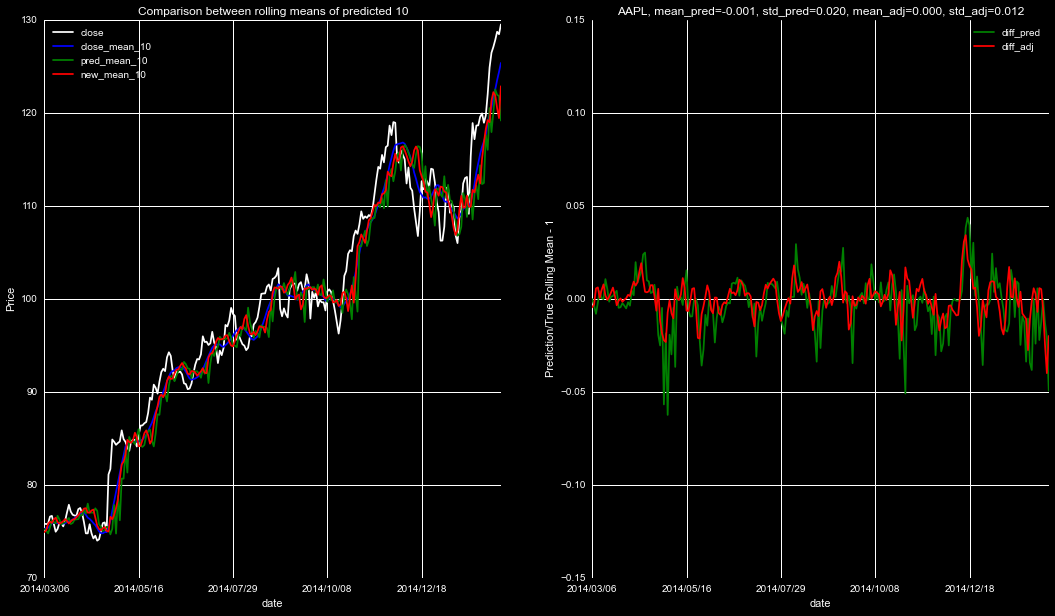

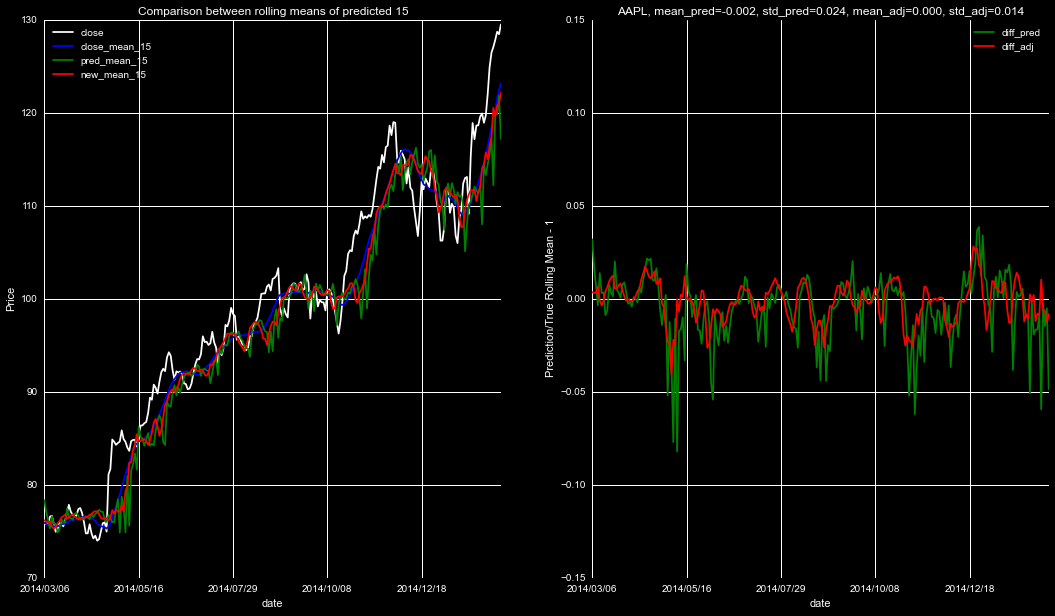

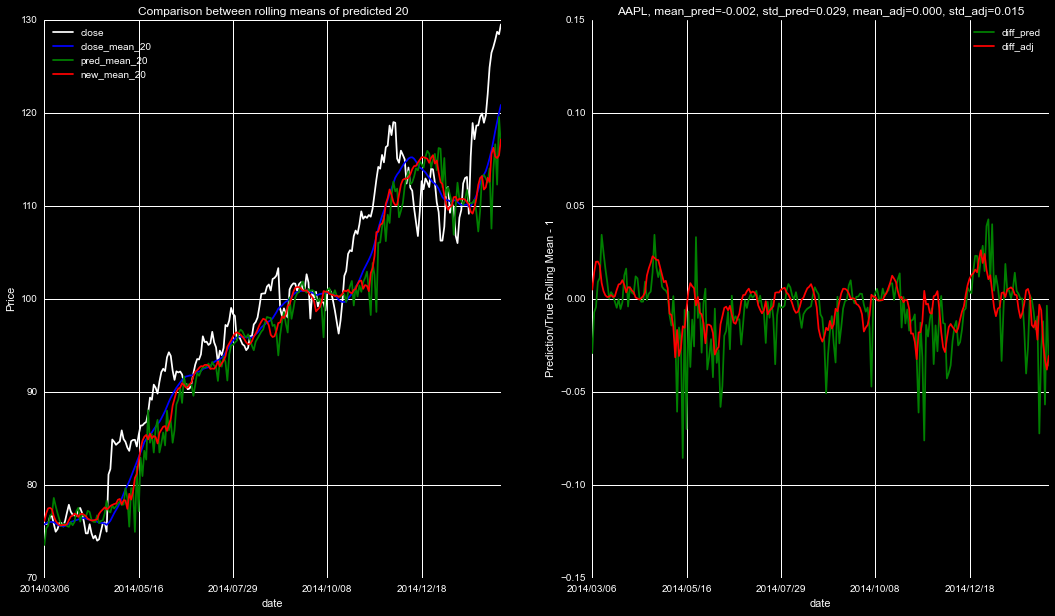

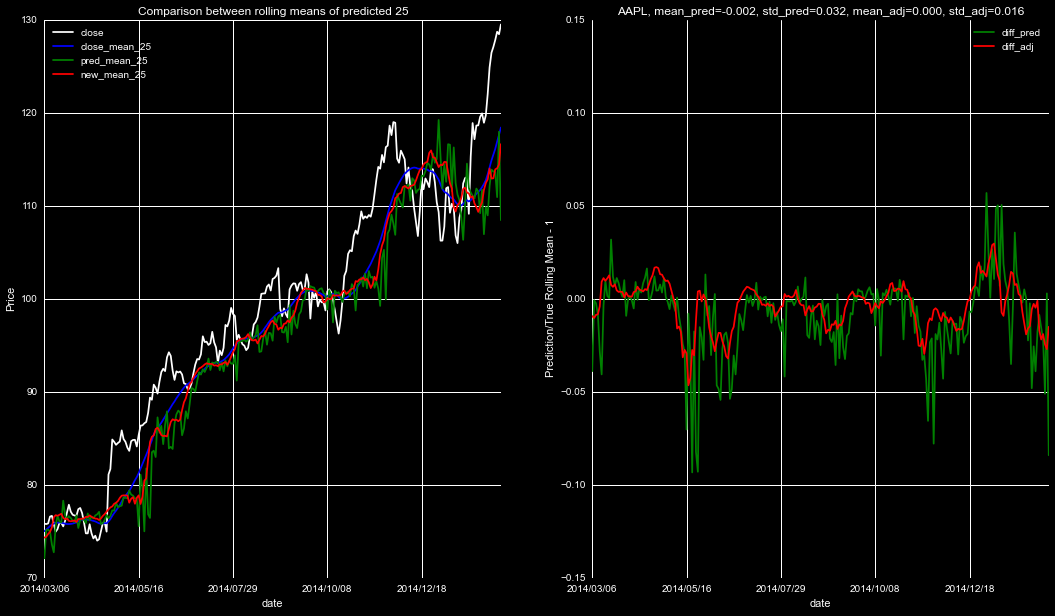

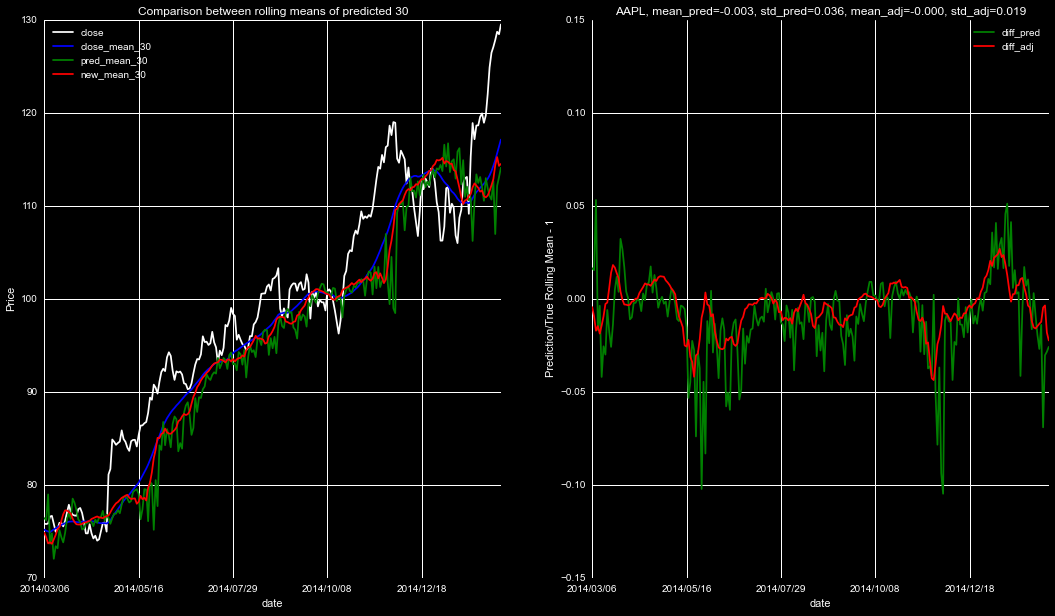

In [287]:
max_ind = close_df.shape[0]
low = int( 0.2*max_ind )
hi  = int( 0.3*max_ind )
for i in roll_nums:

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,10) )

    close_df[hi:low:-1].plot( y = 'close'             , color='w', ax=ax1 )
    close_df[hi:low:-1].plot( y = 'close_mean_'+str(i), color='b', ax=ax1 )
    close_df[hi:low:-1].plot( y =  'pred_mean_'+str(i), color='g', ax=ax1 )
    close_df[hi:low:-1].plot( y =   'new_mean_'+str(i), color='r', ax=ax1 )    
    ax1.set_title( 'Comparison between rolling means of predicted ' + str(i)) #+ ' day rolling mean for AAPL' )
    ax1.set_ylabel( 'Price' )
    
    close_df['diff_pred'] = close_df['pred_mean_'+str(i)] / close_df['close_mean_'+str(i)] - 1.
    close_df['diff_adj' ] = close_df[ 'new_mean_'+str(i)] / close_df['close_mean_'+str(i)] - 1.
    
    close_df[hi:low:-1].plot( y='diff_pred', color='g', ax=ax2 )
    close_df[hi:low:-1].plot( y='diff_adj' , color='r', ax=ax2 )
    
    ax2.set_title( 'AAPL, mean_pred=%5.3f, std_pred=%5.3f, mean_adj=%5.3f, std_adj=%5.3f'%(
                   close_df['diff_pred'].mean(),close_df['diff_pred'].std(),
                   close_df['diff_adj' ].mean(),close_df['diff_adj' ].std(),
               ) )
    ax2.set_ylabel( 'Prediction/True Rolling Mean - 1' )
    ax2.set_ylim( [-0.15,0.15] )
    plt.show()

In [205]:
foo = fv.pred_from_mean( close_df, roll_nums )
foo = foo[['close',
           'pred_3_day_1', 'pred_3_day_2', 'pred_3_day_3',
           'pred_5_day_1', 'pred_5_day_2',
           'pred_8_day_1', 'pred_8_day_2', 'pred_8_day_3',
           'pred_10_day_1', 'pred_10_day_2',
           'pred_15_day_1', 'pred_15_day_2', 'pred_15_day_3', 'pred_15_day_4', 'pred_15_day_5',
           'pred_20_day_1', 'pred_20_day_2', 'pred_20_day_3', 'pred_20_day_4', 'pred_20_day_5',
           'pred_25_day_1', 'pred_25_day_2', 'pred_25_day_3', 'pred_25_day_4', 'pred_25_day_5',
           'pred_30_day_1', 'pred_30_day_2', 'pred_30_day_3', 'pred_30_day_4', 'pred_30_day_5'
          ]]

[ 108.43  105.71  107.11  109.99  109.95  110.06  111.73  111.8   111.23
  111.79  111.57  111.46  110.52  109.49  109.9   109.11  109.95  111.03
  112.12  113.95  113.3   115.19  115.19  115.82  115.97  116.64  116.95
  117.06  116.29  116.52] [ 108.43        107.87513555  107.32027109  109.03847844  111.36516424
  110.2768074   111.51513635  112.7534653   111.24221378  110.69636863
  115.39616182  116.43464883  117.47313585  118.51162286  119.55010987
  122.00460823  125.40321252  128.80181681  132.2004211   135.59902539
  123.18585689  118.97388695  114.76191701  110.54994707  106.33797712
  107.95940804  102.85752632   97.7556446    92.65376287   87.55188115]


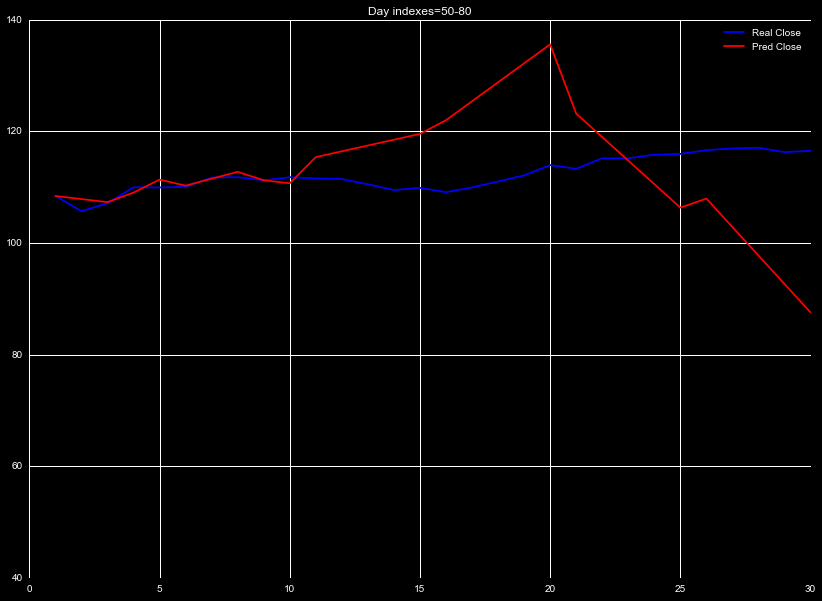

[ 106.73  107.73  107.7   108.36  105.52  103.13  105.44  107.95  111.77
  115.57  114.92  113.58  113.57  113.55  114.62  112.71  112.88  113.09
  113.95  112.18  113.05  112.52  113.    113.05  113.89  114.06  116.05
  116.3   117.34  116.98] [ 106.73        106.6470056   106.5640112   106.6678368   106.70949919
  108.88807226  111.10830772  113.32854319  109.56038814  106.46454896
  108.26017361  107.93511997  107.61006634  107.28501271  106.95995908
  109.74119262  111.33953732  112.93788203  114.53622673  116.13457144
   99.46819894   89.36593663   79.26367431   69.16141199   59.05914968
   81.42421541   83.04462123   84.66502705   86.28543288   87.9058387 ]


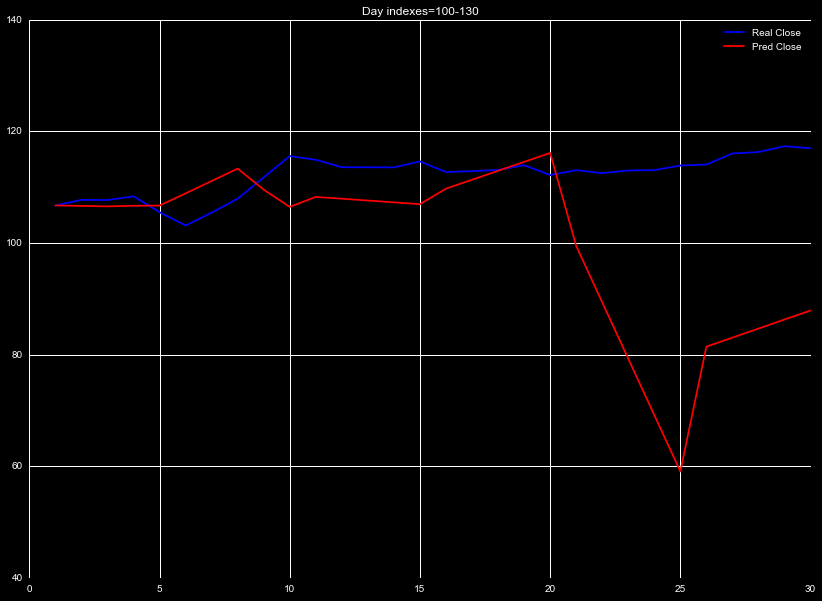

[ 118.63   118.65   119.56   119.94   118.93   119.72   122.02   124.88
  126.46   127.08   127.83   128.715  128.45   129.495  133.     132.17
  128.79   130.415  128.46   129.09   129.36   128.54   126.41   126.6
  127.14   124.51   122.24   124.45   123.59   124.95 ] [ 118.63        117.72681574  116.82363147  114.2220811   107.21261184
  117.21633322  120.21058534  123.20483746  116.19134037  108.15285044
  112.46774524  111.53684645  110.60594767  109.67504888  108.7441501
  107.22625755  104.69148996  102.15672237   99.62195478   97.08718719
  110.15733987  116.15780299  122.15826612  128.15872924  134.15919236
  121.70258266  121.36082007  121.01905747  120.67729488  120.33553229]


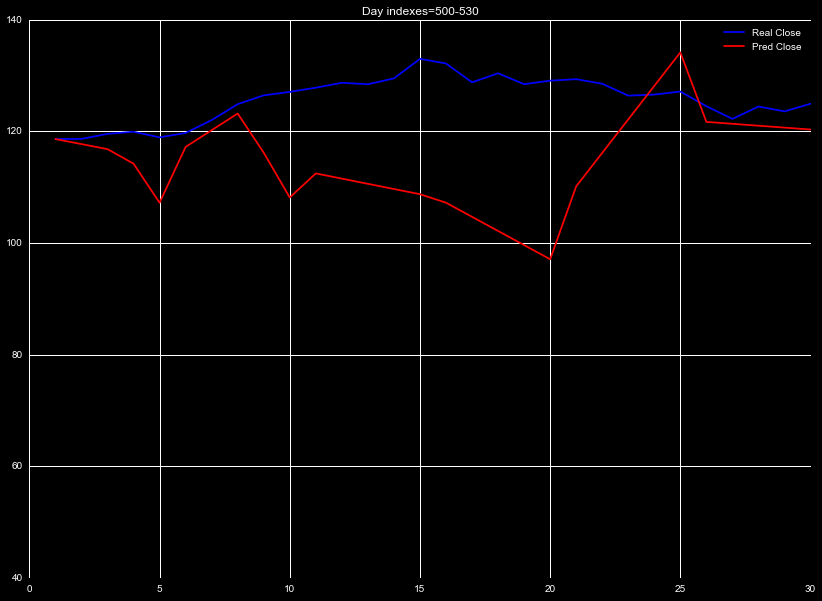

[ 65.3357  66.8886  67.8543  68.5614  66.8428  66.7157  66.6557  65.7371
  65.7128  64.1214  63.7228  64.4014  63.2571  64.1386  63.51    63.0571
  61.4957  60.0071  61.592   60.8088  61.5117  61.6743  62.5528  61.2043
  61.1928  61.7857  63.38    65.1028  64.9271  64.5828] [  65.3357       63.1732561    61.0108122    63.83559853   65.16028341
   64.33729007   64.8389816    65.34067313   64.84505711   64.85720812
   74.31026747   76.67657007   79.04287266   81.40917525   83.77547784
   75.49394178   72.83224363   70.17054547   67.50884731   64.84714915
   87.87094763  101.14624926  114.42155088  127.6968525   140.97215413
   84.22912632   61.58480789   38.94048947   16.29617104   -6.34814738]


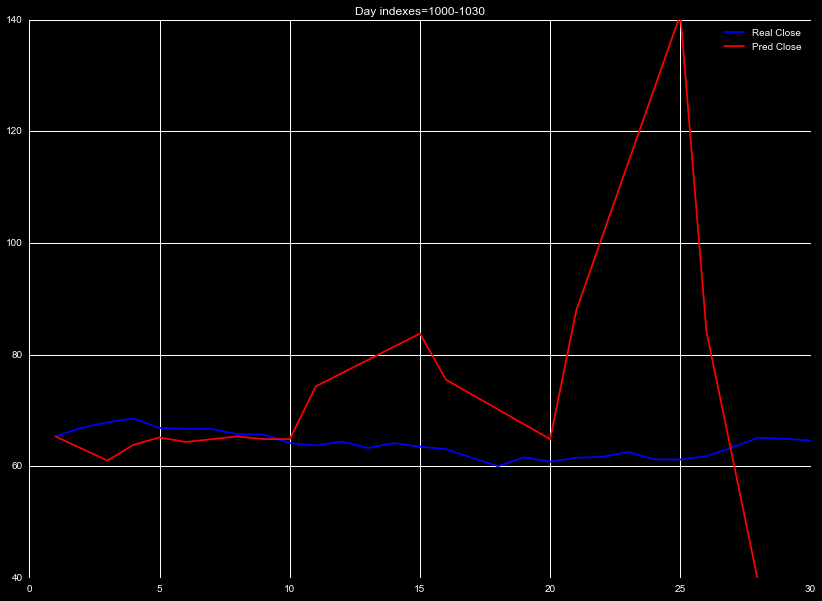

[ 48.8057  49.2028  49.3828  49.7828  48.6643  48.4057  47.5257  46.6743
  48.2071  48.7714  49.1214  49.03    48.0143  48.4743  49.29    49.1886
  49.0628  49.5     50.2686  50.7428  51.1657  50.6486  50.9786  51.3114
  51.4143  51.8757  51.1857  50.08    48.3728  48.9457] [ 48.8057      48.79534622  48.78499245  48.48896091  47.87619029
  45.68754192  42.88612292  40.08470393  44.97707765  49.15898711
  45.40063713  45.506527    45.61241687  45.71830674  45.82419661
  45.8373562   46.00606069  46.17476519  46.34346968  46.51217418
  44.24642282  42.80016604  41.35390926  39.90765248  38.4613957
  42.19229803  42.8210896   43.44988118  44.07867276  44.70746433]


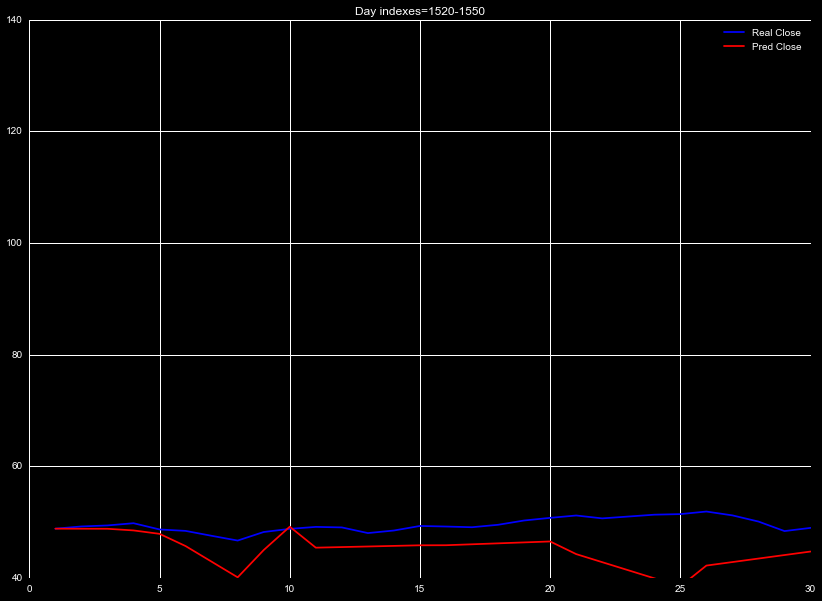

In [206]:
day_list = [ 50, 100, 500, 1000, 1520 ]

day_len = 30

pred_days = range(1,31)#[1,2,3,4,5,6,7,8,9,10,11,13,15,16,18,20,21,23,25,26,28,30]

# Get the real values of the quotes
real_values = []
for i in day_list:
    real_values.append( foo['close'].values[ i:i-day_len:-1 ] )
    
    
# Get predicted values 
pred_values = []
for i in day_list:
    pred_values.append( foo.drop( 'close', axis=1 ).values[ i, 0:len(pred_days) ] )
    
    

# Plot the results
for i in range( 0, len( day_list) ):
    print real_values[i], pred_values[i]
    plt.plot( range( 1, day_len+1 ), real_values[i], color='b', label='Real Close' )
    plt.plot(           pred_days  , pred_values[i], color='r', label='Pred Close' )
    plt.ylim( [40, 140] )
    plt.title( 'Day indexes=%i-%i'%(day_list[i], day_list[i]+30) )
    plt.legend()
    plt.show()